In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from src.common import get_mnist_train_test, get_mnist_labels_categorical, load_layer_activations
from src.common import remove_data_in_last_dim, get_model_prediction
from src.diffAE.models import SAVED_CLASSIFIER_PATH, SAVED_CLADEC_PATH
from src.diffAE.models import SAVED_REFAE_PATH

tf.random.set_seed(1234)
np.random.seed(1234)

In [2]:
# load the data
(dense_train_acts, dense_test_acts), (conv_train_acts, conv_test_acts) = load_layer_activations(SAVED_CLASSIFIER_PATH)
train_images, test_images = get_mnist_train_test()
train_labels_c, test_labels_c = get_mnist_labels_categorical()

# load RefAE model
refae_dense_path = SAVED_REFAE_PATH.joinpath('dense')
refae_conv_path = SAVED_REFAE_PATH.joinpath('conv')
refae_dense = keras.models.load_model(refae_dense_path)
refae_conv = keras.models.load_model(refae_conv_path)

2022-05-27 17:42:14.166905: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 17:42:14.215822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 17:42:14.216151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 17:42:14.217335: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
# load classifier and split classification into correct and wrong
classifier = keras.models.load_model(SAVED_CLASSIFIER_PATH)
classifier_test_out = np.argmax(classifier.predict(test_images), axis=1)
test_labels = np.argmax(test_labels_c, axis=1)
label_comparison = classifier_test_out == test_labels
correct_indices = label_comparison.nonzero()[0]
label_comparison = classifier_test_out != test_labels
wrong_indices = label_comparison.nonzero()[0]

2022-05-27 17:42:18.209724: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8303


313/313 [==============================] - 2s 2ms/step


In [4]:
n_correct = 5
n_wrong = 5
n = n_correct + n_wrong
rand_indices_correct = np.random.choice(correct_indices, n_correct, replace=False)
rand_indices_wrong = np.random.choice(wrong_indices, n_wrong, replace=False)
rand_indices = np.concatenate((rand_indices_correct, rand_indices_wrong))
classes_correct = test_labels[rand_indices]
classes_classified = classifier_test_out[rand_indices]

eval_images = test_images[rand_indices]
eval_dense_acts = dense_test_acts[rand_indices]
eval_conv_acts = conv_test_acts[rand_indices]

eval_refae_dense = refae_dense.predict(eval_images)
eval_refae_conv = refae_conv.predict(eval_images)

1/1 [==============================] - 0s 152ms/step


In [6]:
alpha = 0
cladec_eval_data_dense = []
cladec_eval_data_conv = []
subsets = [30, 60, 75, 90, 100]

for subset_percentage in subsets:
    cladec_path = SAVED_CLADEC_PATH.joinpath(f'cladec_{subset_percentage}').joinpath(f'{alpha:2}')
    cladec_dense_path = cladec_path.joinpath("dense")
    cladec_conv_path = cladec_path.joinpath("conv")
    cladec_eval_data_dense.append(get_model_prediction(cladec_dense_path, eval_dense_acts, subset_percentage))
    cladec_eval_data_conv.append(get_model_prediction(cladec_conv_path, eval_conv_acts, subset_percentage))

1/1 [==============================] - 0s 70ms/step


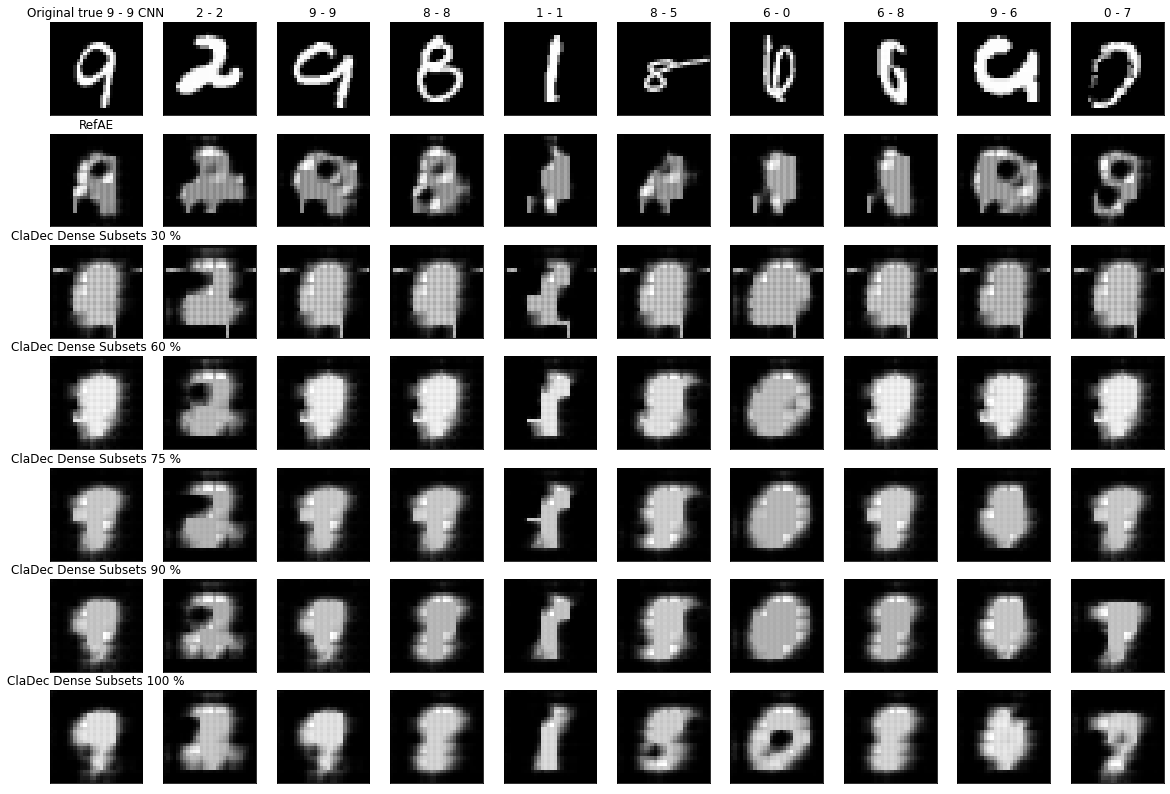

In [7]:
# explaining the dense layer
num_rows = 2 + len(subsets)
plt.figure(figsize=(20, 2 * num_rows))
for i in range(0, n):
    # Display original
    x = i + 1
    ax = plt.subplot(num_rows, n, x)
    title = f'{classes_correct[i]} - {classes_classified[i]}'
    if x == 1:
        ax.set_title("Original true " + title + " CNN")
    else:
        ax.set_title(title)

    plt.imshow(eval_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display refae
    ax = plt.subplot(num_rows, n, x + n)
    if x == 1:
        ax.set_title("RefAE")
    plt.imshow(eval_refae_dense[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display cladec
    j = 2
    for subset, data in zip(subsets, cladec_eval_data_dense):
        ax = plt.subplot(num_rows, n, x + j * n)
        j += 1
        if x == 1:
            ax.set_title(f'ClaDec Dense Subsets {subset} %')
        plt.imshow(data[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

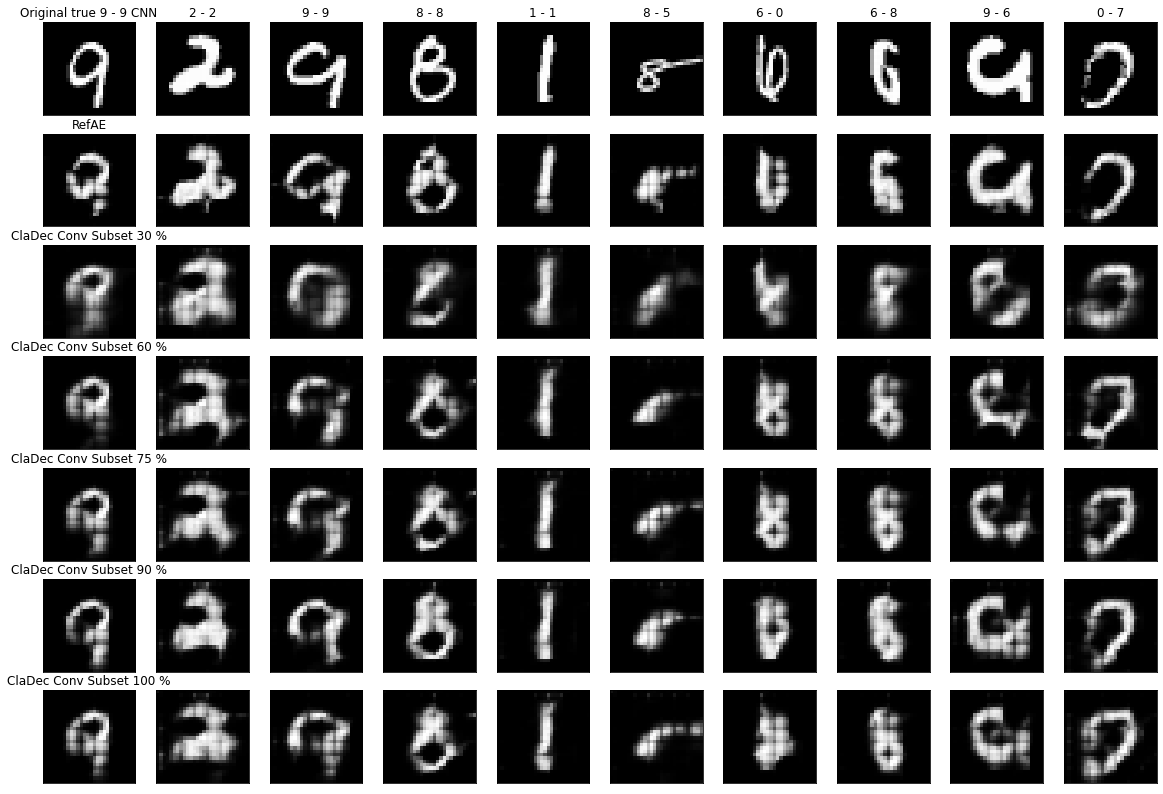

In [8]:
# explaining the conv layer
num_rows = 2 + len(subsets)
plt.figure(figsize=(20, 2 * num_rows))
for i in range(0, n):
    # Display original
    x = i + 1
    ax = plt.subplot(num_rows, n, x)
    title = f'{classes_correct[i]} - {classes_classified[i]}'
    if x == 1:
        ax.set_title("Original true " + title + " CNN")
    else:
        ax.set_title(title)

    plt.imshow(eval_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display refae
    ax = plt.subplot(num_rows, n, x + n)
    if x == 1:
        ax.set_title("RefAE")
    plt.imshow(eval_refae_conv[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display cladec
    j = 2
    for subset, data in zip(subsets, cladec_eval_data_conv):
        ax = plt.subplot(num_rows, n, x + j * n)
        j += 1
        if x == 1:
            ax.set_title(f'ClaDec Conv Subset {subset} %')
        plt.imshow(data[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()